Tommaso Peritore

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib.gridspec import GridSpec


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
#from tensorflow.keras import backend as K
#from tensorflow.keras.utils import get_custom_objects

import itertools

import seaborn as sns
sns.set_theme(style='darkgrid')

%config InlineBackend.figure_format = 'retina'


# Exercise 11

## Overview 


In this notebook our task will be to perform machine learning regression on noisy data with a Neural Network (NN).

We will explore how the ability to fit depends on the structure of the NN. The goal is also to build intuition about why prediction is difficult.

## 11.1

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

## Solution

We will try to improve the fitting of the following function:
$$
f(x)=2x+1
$$
We want to explore how the linear regression depends on the number of epochs, the number of data points and the noise $\sigma$. Thus we are interested in seeing how these parameters affect the ability of the NN to fit the data.

To explore the effect of all parameters we will define a set of values for each and then loop over all possible combinations of these values. Below I am showing the values for the $3$ parameters.

In [4]:
# Parameters to vary
_sigma = [0.1, 0.2, 0.5, 1] # <<< noise
_n_epochs = [10, 15, 30, 50] # <<< epochs
_n_train = [500, 1000, 1500, 2000] # <<< train

N_valid = 50 # <<< test

# target parameters of f(x) = m*x + q
m = 2 # slope
q = 1 # intersect

print('Sigma = ', _sigma)
print('N_epochs = ', _n_epochs)
print('N_train = ', _n_train)

Sigma =  [0.1, 0.2, 0.5, 1]
N_epochs =  [10, 15, 30, 50]
N_train =  [500, 1000, 1500, 2000]


The parameters to explore were chosen with these criteria in mind:
- The values of sigma were chosen to span from very low noise to very high noise so as to explore the ability of the NN model to fit the data in the presence of progressively more noise.
- The number of epochs was chosen to span from below to above the value given in the original code, to see if $30$ epochs was already enough to saturate the training or if more epochs would improve the fit, or if less epochs would be enough.
- Finally, the number of training data was varied significantly to see if the model would perform better after having been trained on more data.

Below I am going to define a function to prepare the data, define the model, compile it and finally train it. This function, `run_model` will be used to fill a `loss` array with the values of the loss function for each combination of parameters.

In [5]:
# Define the function for the NN model
def run_model (sigma, n_epochs, train, valid):
	# generate training inputs
	np.random.seed(0)
	x_train = np.random.uniform(-1, 1, train)
	x_valid = np.random.uniform(-1, 1, valid)
	x_valid.sort()
	# y_target = m * x_valid + q # ideal (target) linear function

	# actual measures from which we want to guess regression parameters
	y_train = np.random.normal(m * x_train + q, sigma) 
	y_valid = np.random.normal(m * x_valid + q, sigma)

	# compose the NN model
	model = tf.keras.Sequential()
	model.add(Dense(1, input_shape = (1,)))

	# compile the model choosing optimizer, loss and metrics objects
	model.compile(optimizer = 'sgd', loss = 'mse', metrics = ['mse'])

	# train the model
	model.fit(x = x_train, y = y_train, batch_size = 32, epochs = n_epochs,
                    shuffle = True, validation_data = (x_valid, y_valid))
	score = model.evaluate(x_valid, y_valid, batch_size = 32, verbose = 0)
	
	return score[0]	

In [6]:
# Iterate model over all combinations of parameters
param_combinations = list(itertools.product(_sigma, _n_epochs, _n_train))

loss = []

for combination in param_combinations:
	loss.append(run_model (combination[0], combination[1], combination[2], N_valid))

Epoch 1/10
16/16 [==============================] - 0s 8ms/step - loss: 0.9665 - mse: 0.9665 - val_loss: 0.7166 - val_mse: 0.7166
Epoch 2/10
16/16 [==============================] - 0s 2ms/step - loss: 0.5752 - mse: 0.5752 - val_loss: 0.4386 - val_mse: 0.4386
Epoch 3/10
16/16 [==============================] - 0s 2ms/step - loss: 0.3576 - mse: 0.3576 - val_loss: 0.2820 - val_mse: 0.2820
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 0.2339 - mse: 0.2339 - val_loss: 0.1896 - val_mse: 0.1896
Epoch 5/10
16/16 [==============================] - 0s 2ms/step - loss: 0.1602 - mse: 0.1602 - val_loss: 0.1339 - val_mse: 0.1339
Epoch 6/10
16/16 [==============================] - 0s 7ms/step - loss: 0.1153 - mse: 0.1153 - val_loss: 0.0992 - val_mse: 0.0992
Epoch 7/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0869 - mse: 0.0869 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 8/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0678 - mse: 0.06

Finally now that we have the loss array, we are going to visualize the data obtained. I am using heatmaps to visualize the loss obtained from the model as a function of the number of epochs, the number of training data and the noise $\sigma$. With fixed number of `N_train`, each heatmap gives the values of the loss with respect to the number of epochs (on the x-axis) and the noise $\sigma$ (on the y-axis). 

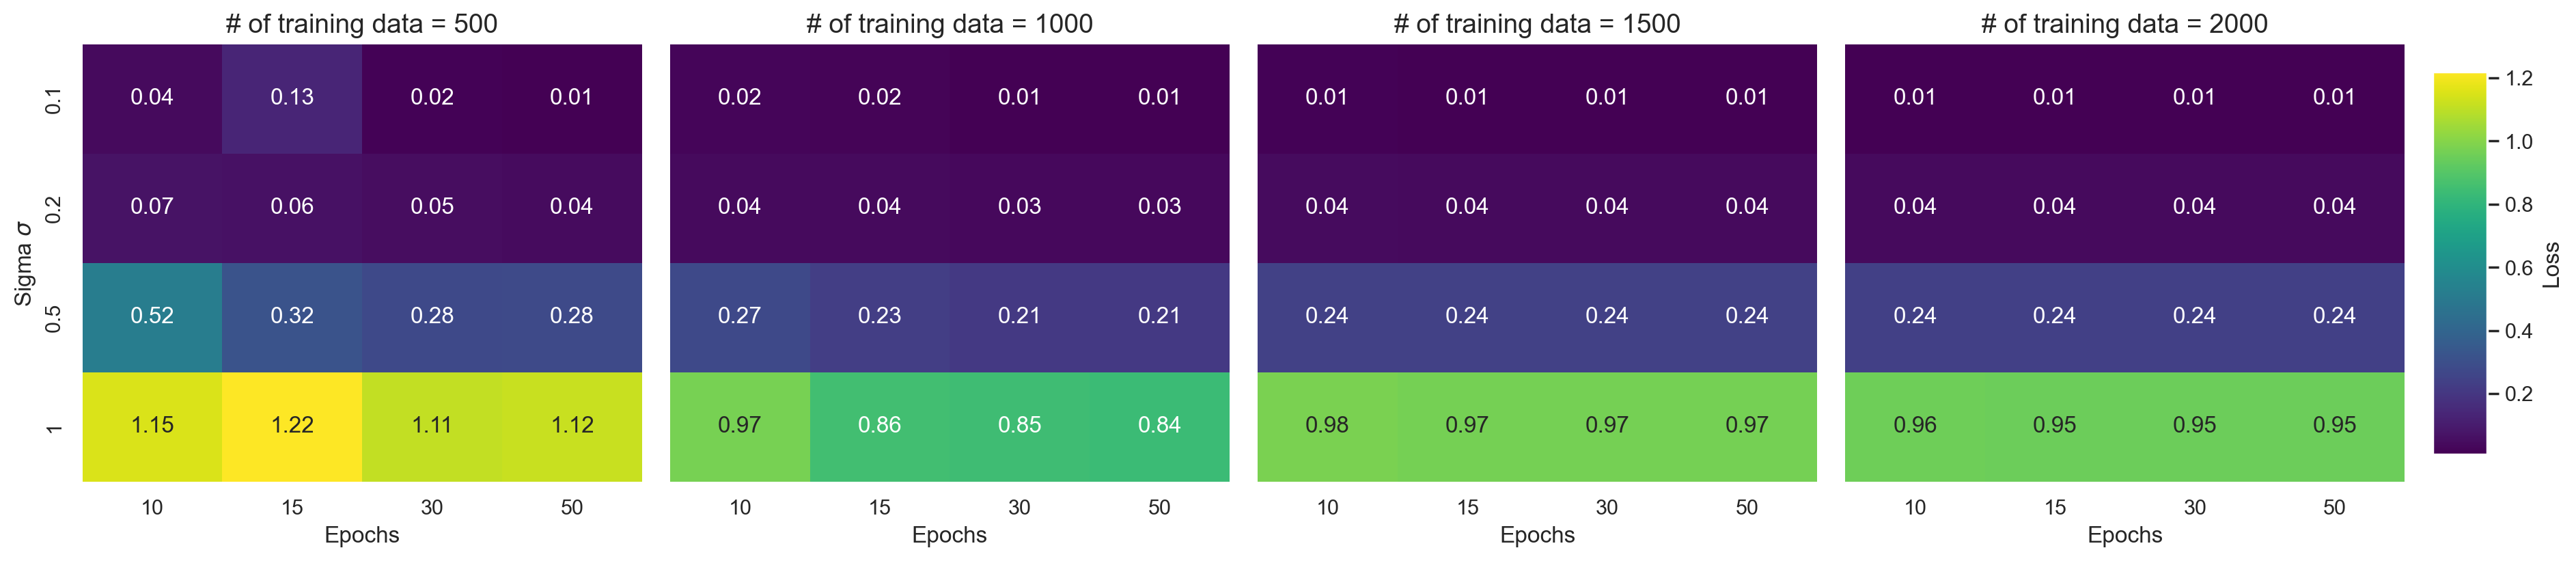

In [7]:
# Function to plot heatmaps
def plot_heatmaps(loss, param_combinations, sigma_values, n_epochs_values, n_train_values):
    fig = plt.figure(figsize=(20, 4))
    gs = GridSpec(1, len(n_train_values), width_ratios=[1]*len(n_train_values), wspace=0.05)
    
    # Calculate the min and max of the loss values
    vmin = min(loss)
    vmax = max(loss)
    
    axes = []
    for i, n_train in enumerate(n_train_values):
        ax = fig.add_subplot(gs[i])
        axes.append(ax)
        
        # Filter the loss values for the current n_train
        filtered_loss = [loss[j] for j in range(len(loss)) if param_combinations[j][2] == n_train]
        
        # Reshape the filtered loss into a matrix
        loss_matrix = np.array(filtered_loss).reshape(len(sigma_values), len(n_epochs_values))
        
        # Plot heatmap
        sns.heatmap(
            loss_matrix, annot=True, fmt='.2f', ax=ax, cmap='viridis', vmin=vmin, vmax=vmax,
            cbar=False,  # Disable individual colorbars
            xticklabels=n_epochs_values, yticklabels=sigma_values
        )
        
        ax.set_title(f'# of training data = {n_train}', fontsize=14)
        ax.set_xlabel('Epochs', fontsize=12)
        
        if i == 0:
            ax.set_ylabel('Sigma $\sigma$', fontsize=12)
        else:
            ax.set_ylabel('')
            ax.tick_params(labelleft=False)
    
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.2)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
    plt.colorbar(axes[0].collections[0], cax=cbar_ax).set_label('Loss')
    
    plt.show()

# Plot the heatmaps
plot_heatmaps(loss, param_combinations, _sigma, _n_epochs, _n_train)

Despite being not too easy to read as a data visualization method, these heatmaps actually contain a lot of information about the performance of the model. Let us draw some conclusions from the heatmaps.

First off, looking at the difference of the same point in the heatmaps (fixed sigma and epochs) throughout the difference plots, i.e. different number of traning data, we can see how the loss function does not decrease directly with the increase of training data: it saw an improvement when going from $500$ to $1000$, but after that the loss got worse. We can interpret this as an overfitting of the model where more training data resulted in a worse prediction of the test data.

The second observation is that with fixed sigma and number of training data, the loss did not vary significantly with the number of epochs (horizontally within a heatmap) especially for higher training data. This shows how the number of epochs does not affect the loss function significantly, and that the model saturates after a certain number of epochs. This number can be seen varying with training data, but we can affirm that after $15$ epochs, the loss does not get much better.

Finally, we can see that the loss function increases with the noise $\sigma$, as expected.

In conclusion, the ideal number of training data was evidently $1000$. With this training data $30$ epochs were enough to saturate the model, and the noise $\sigma$ should be kept as low as possible to have a good fit.

### Backend


Here is an alternate visualization that I tried, with a 3D plot rather than a heatmap. Not particularly clear.

In [8]:
# Separate the parameters and losses into individual arrays
sigma, n_train, n_epochs = zip(*param_combinations)
loss = np.array(loss)

# Create a trace for the 3D plot
trace = go.Scatter3d(
    x=sigma,
    y=n_train,
    z=n_epochs,
    mode='markers',
    marker=dict(
        size=4,
        color=loss,  # Use the log-transformed loss for coloring
        colorscale='Viridis',
        colorbar=dict(title='Log(Loss)'),
        opacity=0.9
    ),
    text=[f'Sigma: {s}<br>Train data: {t}<br>Epochs: {e}<br>Loss: {l:.4f}'
          for s, t, e, l in zip(sigma, n_train, n_epochs, loss)],
    hoverinfo='text'
)

# Create the layout
layout = go.Layout(
    title='3D Scatter Plot of Loss with Different Parameters',
    scene=dict(
        xaxis=dict(title=f'sigma', titlefont=dict(size=12)),
        yaxis=dict(title='train data', titlefont=dict(size=12)),
        zaxis=dict(title='epochs', titlefont=dict(size=12))
    ),
    width=900,  # Increase the width of the plot
    height=700,  # Increase the height of the plot
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)


# Show the plot
fig.show()